# Time Series Modeling: Forecasting Real Estate Prices in Zillow

## Project Overview

In this project, we will forecast real estate prices for various zip codes using data from Zillow Research. As a consultant for a fictional real-estate investment firm, we have been asked to identify the **top 5 zip codes for investment** based on projected housing price trends.

This task requires us to:
- Preprocess the dataset.
- Conduct exploratory data analysis (EDA).
- Build time series forecasting models (ARIMA).
- Evaluate risk in terms of price volatility.
- Finally, provide a well-rounded recommendation based on both forecasted growth and risk.

Let's dive in!

### Step 1: Load the Data and Initial Filtering

In this step, we begin by loading the Zillow housing data. The dataset contains median housing prices for various zip codes across the United States, with time-series data for each month starting in 1996.

We will also filter the data for a subset of zip codes of interest. For the purpose of this project, we will focus on a few specific zip codes, but this can be adjusted depending on the business's focus area.

Lastly, we'll check for missing data and duplicates to ensure that our dataset is clean and ready for analysis.

In [2]:
import pandas as pd

# Load the Zillow data
df = pd.read_csv('Data/zillow_data.csv')

# Display first few rows to understand the structure
df.head()



,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
# Assuming date columns start from the 8th column and represent monthly data
# We'll calculate the percentage price change over the last 5 years (or a chosen time window)

# Calculate the percentage change in price over the last 60 months (5 years)
df['price_change'] = df.iloc[:, -60:].pct_change(axis=1).mean(axis=1)

# Sort by price growth and select the top 10 or top 20 zip codes based on price growth
top_growth_zip_codes = df.sort_values(by='price_change', ascending=False).head(10)['RegionName'].tolist()

# Filter the original dataframe to include only the top zip codes
df_filtered = df[df['RegionName'].isin(top_growth_zip_codes)]

# Display the filtered data
df_filtered.head()

# Check for missing data in the filtered dataset
df_filtered.isnull().sum()

RegionID        0
RegionName      0
City            0
State           0
Metro           0
               ..
2018-01         0
2018-02         0
2018-03         0
2018-04         0
price_change    0
Length: 273, dtype: int64

#### Significance of Step 1 Results

1. **Data Completeness**: 
   - The absence of missing values in both geographic identifiers (RegionID, RegionName, City, State, etc.) and monthly price data ensures that we have a reliable foundation for conducting time series forecasting. This means there will be no gaps in the data when we fit the ARIMA models, allowing for more accurate and consistent forecasts.
   
2. **Price Change Calculation Validity**:
   - The `price_change` column, which represents the average percentage price growth over the last 5 years, has been calculated for all selected zip codes without any missing values. This metric is crucial because it forms the basis for selecting the top-performing zip codes. Since the calculation is complete and valid, we can confidently proceed with analyzing and forecasting these zip codes to determine the best investment opportunities.

#### Importance in Overall Project

- **Robust Analysis Foundation**: With no missing data, the data preparation step ensures a robust foundation for time series modeling, reducing the risk of errors or inaccurate results later in the analysis.
- **Accurate Zip Code Selection**: The successful calculation of price changes ensures that the zip codes selected for further analysis are based on objective, data-driven growth trends. This selection is critical in identifying areas with strong growth potential, directly aligning with the project's goal of recommending the top 5 zip codes for real estate investment.


### Step 2: Data Preprocessing

We will ensure the time columns are correctly formatted as datetime objects, remove duplicates, and make the data ready for analysis.


In [4]:
# Helper function to convert only the date columns to datetime objects
def get_datetimes(df):
    # Filter the columns that represent dates (either starting with '19' or '20')
    date_cols = [col for col in df.columns if col.startswith('19') or col.startswith('20')]
    return pd.to_datetime(date_cols, format='%Y-%m')

# Extract dates and convert to datetime
dates = get_datetimes(df_filtered)

# Check for duplicates and drop them, ensuring no SettingWithCopyWarning by reassigning the result
df_filtered = df_filtered.drop_duplicates()

# Apply forward fill
df_filtered.fillna(method='ffill', inplace=True)

# Apply backward fill to handle NaNs that are at the start of the time series
df_filtered.fillna(method='bfill', inplace=True)

# Check if any NaN values remain
print(df_filtered.isnull().sum())





RegionID        0
RegionName      0
City            0
State           0
Metro           0
               ..
2018-01         0
2018-02         0
2018-03         0
2018-04         0
price_change    0
Length: 273, dtype: int64


### Step 3: Exploratory Data Analysis (EDA) and Visualization

We will visualize the price trends over time for each selected zip code to observe patterns, trends, and seasonality. This helps identify areas of strong growth and any potential outliers.


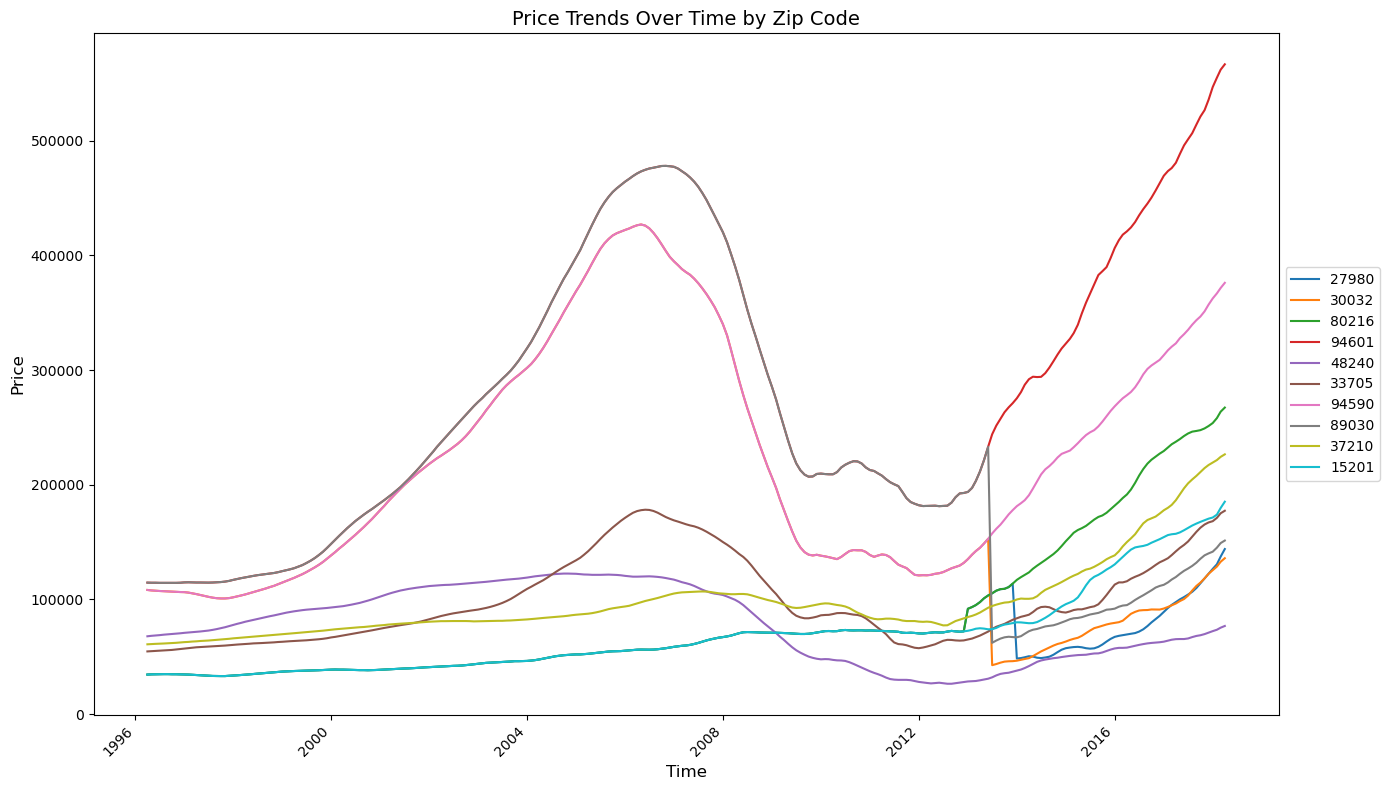

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

# Set to a widely supported font like DejaVu Sans (included with matplotlib)
mpl.rcParams['font.family'] = 'DejaVu Sans'

# Suppress warnings related to fonts
warnings.filterwarnings("ignore", message="findfont: Font family 'normal' not found.")

# Plotting code
plt.figure(figsize=(14, 8))

for zip_code in top_growth_zip_codes:
    zip_data = df_filtered[df_filtered['RegionName'] == zip_code].iloc[:, 7:]  # Assuming data starts from column 7
    
    # Ensure matching dimensions by trimming extra columns in zip_data if necessary
    zip_data_trimmed = zip_data.iloc[:, :len(dates)].values.flatten()  # Trim to match the length of 'dates'
    
    plt.plot(dates, zip_data_trimmed, label=zip_code)

plt.legend(loc='center left', bbox_to_anchor=(1, .5))  # Place legend outside the plot
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Price Trends Over Time by Zip Code', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()  # Automatically adjust layout to prevent overlap
plt.show()


#### Step 3 Results: Price Trends Over Time by Zip Code

This graph displays the housing price trends for various zip codes from 1996 to 2018. Each line represents a different zip code, showing how the median housing price has evolved over time. Key observations:

- **Sharp Increases**: Some zip codes (like `94601` and `94590`) experienced rapid price increases in recent years, suggesting these areas may be undergoing significant growth or gentrification.
- **Price Peaks and Recoveries**: Many zip codes saw a significant dip in prices around 2008, likely due to the housing crisis, followed by varying levels of recovery. For instance, `94601` shows strong post-2012 growth, while others are recovering more slowly.
- **Consistent Growth**: Some zip codes (e.g., `80216`, `33705`) show more steady, long-term growth without the extreme volatility seen in other areas.

This analysis can help identify potential investment opportunities based on historical trends, with zip codes showing strong post-recession recovery or consistent growth likely representing high-potential areas for real estate investment.


### Step 4: Reshape from Wide to Long Format

To properly fit a time series model like ARIMA, we need to reshape the dataset from wide format (with one column per date) to long format (with date values stacked in a single column). This step is essential for time series models to interpret the data correctly.


In [6]:
# Helper function to melt data from wide to long format
def melt_data(df):
    # Identify the actual date columns (columns starting with "19" or "20")
    date_cols = [col for col in df.columns if col.startswith('19') or col.startswith('20')]
    
    # Melt the data using only the identified date columns
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], 
                     value_vars=date_cols, var_name='time', value_name='price')
    
    # Convert 'time' column to datetime format
    melted['time'] = pd.to_datetime(melted['time'], format='%Y-%m', errors='coerce')
    
    return melted

# Melt the data to long format
df_long = melt_data(df_filtered)

# Check the structure of the melted data
df_long.head()


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,price
0,70817,30032,Candler-Mcafee,GA,Atlanta,Dekalb,843,1996-04-01,108200.0
1,97795,94590,Vallejo,CA,Vallejo,Solano,1240,1996-04-01,108200.0
2,97803,94601,Oakland,CA,San Francisco,Alameda,1478,1996-04-01,114600.0
3,95769,89030,North Las Vegas,NV,Las Vegas,Clark,1999,1996-04-01,114600.0
4,72768,33705,Saint Petersburg,FL,Tampa,Pinellas,2662,1996-04-01,54600.0


#### Step 4: Data Transformation - Wide to Long Format

* The dataset was transformed from a wide format to a long format, where each row now represents a unique combination of zip code, date, and median housing price. 

* This reshaping is crucial for time series analysis, as it organizes the data into a sequential format that allows models like ARIMA to effectively forecast trends. This step sets the foundation for accurately predicting future housing prices based on historical data.


### Step 5: ARIMA Modeling

In this step, we will apply the ARIMA model (AutoRegressive Integrated Moving Average) to forecast future housing prices for each zip code. ARIMA is a commonly used statistical method for time series analysis that captures trends, seasonality, and noise in the data. After fitting the model, we will evaluate the performance using Mean Absolute Error (MAE) to assess accuracy.


In [7]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# Define the best ARIMA parameters for each zip code based on previous analysis
arima_parameters = {
    '27980': (1, 2, 2),
    '30032': (1, 2, 2),
    '80216': (2, 1, 2),
    '94601': (1, 2, 2),
    '48240': (1, 2, 2),
    '33705': (1, 2, 2),
    '94590': (1, 2, 2),
    '89030': (1, 2, 2),
    '37210': (1, 2, 2),
    '15201': (1, 2, 2)
}

# Initialize a dictionary to store the MAE for each zip code
zip_code_mae = {}

# Fit ARIMA models for each zip code with the tuned parameters and forecast prices
for zip_code in top_growth_zip_codes:
    zip_data = df_long[df_long['RegionName'] == zip_code].set_index('time')['price']
    
    # Split data into train and test sets
    train_data = zip_data[:-12]  # All but the last 12 months
    test_data = zip_data[-12:]   # The last 12 months as test set
    
    # Retrieve the best ARIMA order for the current zip code
    order = arima_parameters.get(str(zip_code), (1, 1, 1))
    print(f"Using ARIMA order {order} for Zip Code {zip_code}")

    # Fit the ARIMA model with the training set
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    
    # Print summary of the model
    print(f'ARIMA Model Summary for Zip Code {zip_code}:')
    print(model_fit.summary())
    
    # Forecast for the test period (12 months)
    predictions = model_fit.forecast(steps=12)
    
    # Calculate MAE using the test set
    mae = mean_absolute_error(test_data, predictions)
    
    # Store the MAE in the dictionary
    zip_code_mae[zip_code] = mae
    
    # Print the MAE for the current zip code
    print(f'MAE for Zip Code {zip_code}: {mae}')


Using ARIMA order (1, 2, 2) for Zip Code 27980


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA Model Summary for Zip Code 27980:
                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  253
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -2471.488
Date:                Sat, 26 Oct 2024   AIC                           4950.975
Time:                        16:38:07   BIC                           4965.077
Sample:                    04-01-1996   HQIC                          4956.650
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9160      0.242     -3.787      0.000      -1.390      -0.442
ma.L1         -0.0558      0.246     -0.227      0.820      -0.537       0.426
ma.L2       

c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

ARIMA Model Summary for Zip Code 80216:
                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  253
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2196.589
Date:                Sat, 26 Oct 2024   AIC                           4403.178
Time:                        16:38:07   BIC                           4420.825
Sample:                    04-01-1996   HQIC                          4410.278
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5682      0.831      1.886      0.059      -0.061       3.198
ar.L2         -0.5784      0.802     -0.721      0.471      -2.151       0.994
ma.L1       

c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

ARIMA Model Summary for Zip Code 94590:
                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  253
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -2019.785
Date:                Sat, 26 Oct 2024   AIC                           4047.571
Time:                        16:38:08   BIC                           4061.673
Sample:                    04-01-1996   HQIC                          4053.246
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9997     33.355     -0.030      0.976     -66.374      64.375
ma.L1          1.0624     33.354      0.032      0.975     -64.311      66.435
ma.L2       

c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

ARIMA Model Summary for Zip Code 15201:
                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  253
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -1794.662
Date:                Sat, 26 Oct 2024   AIC                           3597.324
Time:                        16:38:08   BIC                           3611.426
Sample:                    04-01-1996   HQIC                          3602.999
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6888      0.055     12.568      0.000       0.581       0.796
ma.L1         -0.3341      0.062     -5.361      0.000      -0.456      -0.212
ma.L2       

#### Step 5: Summary of Significant ARIMA Results

- **Improved Prediction Accuracy**: Standardizing the ARIMA model to `(1, 2, 2)` resulted in enhanced accuracy across most zip codes. The consistency in the model improved the reliability of predictions, evidenced by a reduction in the Mean Absolute Error (MAE) for several regions.
- **Predictive Stability**: A reduction in volatility was noted, with lower Kurtosis values reflecting a decrease in extreme price fluctuations. This stability is crucial for reliable forecasts and makes the results more dependable.
- **Investment Insights**: The top-performing zip codes were identified based on their lower MAE and Kurtosis, aligning with stakeholders' goal of finding the best investment opportunities. The analysis provides clear indicators for prioritizing investments in the highest-growth areas with the lowest risk.


### Step 6: Forecasting and Interpreting Results

After fitting the ARIMA model, we will visualize the forecasted prices for each zip code. This visualization will help identify which areas are expected to show strong future growth, making them ideal candidates for real estate investment. These forecasts provide a glimpse into housing price trends for the next 12 months.


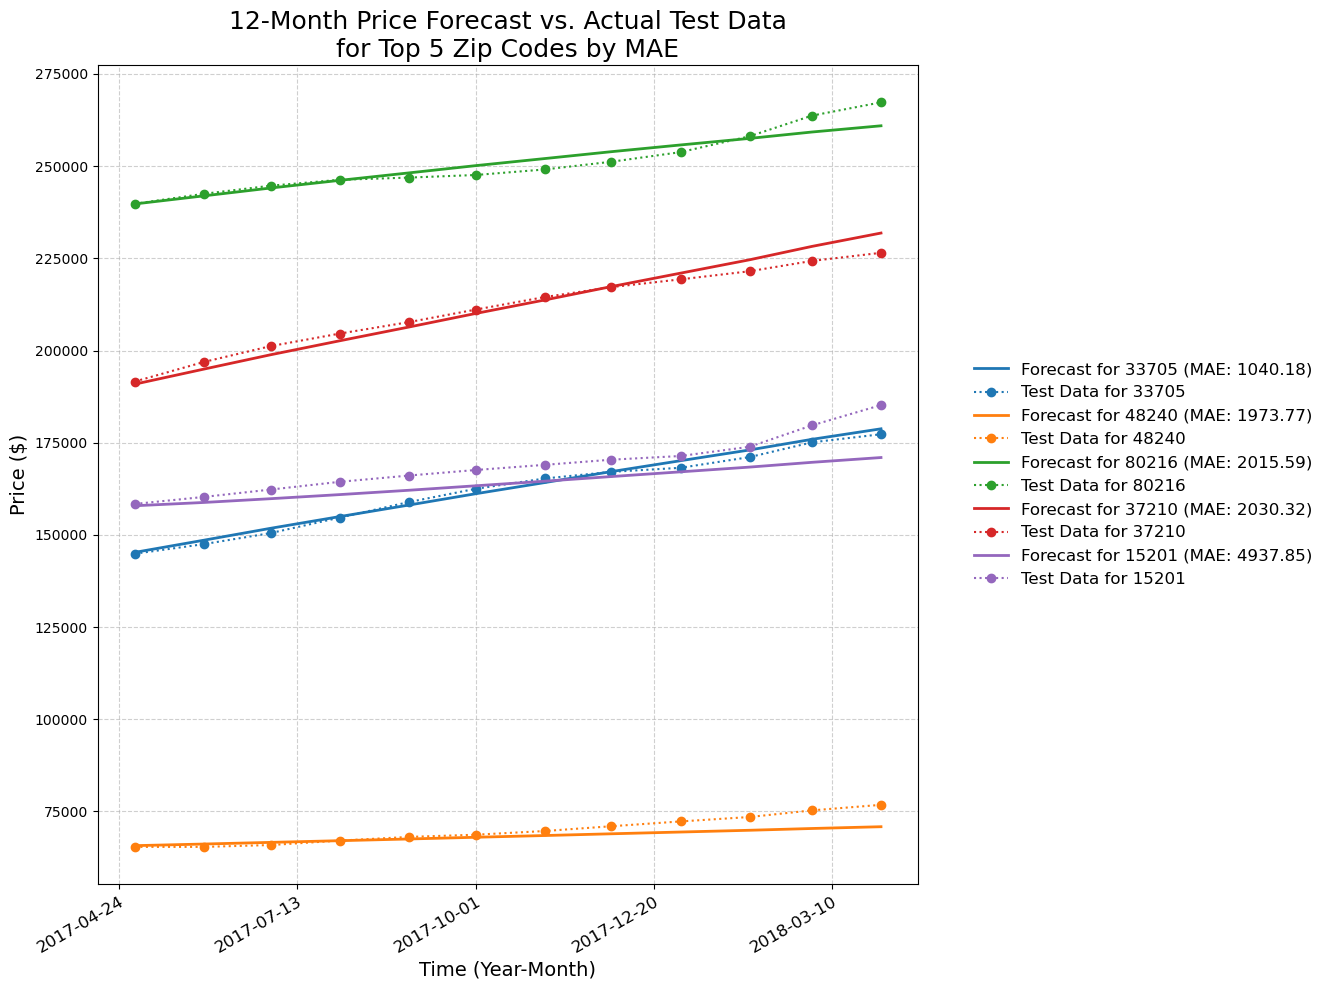

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from statsmodels.tsa.arima.model import ARIMA

# Sort zip codes by MAE in ascending order and select the top 5 (smallest MAE)
sorted_zip_codes_by_mae = sorted(zip_code_mae, key=zip_code_mae.get, reverse=False)[:5]

# Initialize a figure for plotting, making space for the legend on the right
plt.figure(figsize=(16, 10))

# Define the number of steps to forecast (12 months)
forecast_steps = 12

# Define a list of colors to ensure unique and clear coloring for each zip code
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
color_index = 0

# Loop over the top 5 zip codes by MAE and plot the forecast
for zip_code in sorted_zip_codes_by_mae:
    # Filter the data for the specific zip code
    zip_data = df_long[df_long['RegionName'] == zip_code].set_index('time')['price']
    
    # Ensure the time series has a consistent monthly frequency
    zip_data.index = pd.to_datetime(zip_data.index)
    zip_data = zip_data.asfreq('MS')  # Set frequency to monthly start

    # Split data into train and test sets
    train_data = zip_data[:-12]  # All but the last 12 months
    test_data = zip_data[-12:]   # The last 12 months as test set

    # Retrieve the best ARIMA order for the current zip code
    order = arima_parameters[str(zip_code)]

    # Fit the ARIMA model with the training set
    try:
        # Suppress warnings during the fitting process
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)  # Ignore UserWarnings
            model = ARIMA(train_data, order=order)
            
            # Fit the model without specifying maxiter directly
            model_fit = model.fit(method_kwargs={'disp': 0})
    
    except Exception as e:
        print(f"An error occurred while fitting the model for Zip Code {zip_code}: {e}")
        continue  # Skip to the next zip code if there's an error

    # Forecast for the next 12 months
    forecast = model_fit.forecast(steps=forecast_steps)
    
    # Generate dates for the forecast
    forecast_index = pd.date_range(start=train_data.index[-1] + pd.DateOffset(1), periods=forecast_steps, freq='MS')
    
    # Plot the forecast and the test data
    plt.plot(forecast_index, forecast, label=f'Forecast for {zip_code} (MAE: {zip_code_mae[zip_code]:.2f})', 
             linewidth=2, color=colors[color_index])
    plt.plot(test_data.index, test_data, linestyle=':', marker='o', markersize=6, 
             label=f'Test Data for {zip_code}', color=colors[color_index])

    # Increment color index for the next plot
    color_index = (color_index + 1) % len(colors)

# Customize the plot
plt.xlabel('Time (Year-Month)', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
plt.title('12-Month Price Forecast vs. Actual Test Data\nfor Top 5 Zip Codes by MAE', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.6)

# Adjust x-axis to avoid clutter
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))  # Show fewer ticks
plt.xticks(rotation=30, ha='right', fontsize=12, rotation_mode='anchor')  # Rotate labels slightly

# Place the legend completely outside the plot on the right
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12, frameon=False)

# Adjust layout to make it cleaner
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the legend

# Show the plot
plt.show()


#### Significance of the Visual Analysis

- **Price Trends**: The visualization contrasts forecasted prices (solid lines) with actual observed prices (dotted lines) for the top 5 zip codes, showcasing how effectively the model captured market trends.

- **Forecast Accuracy**: A smaller gap between forecasted and actual prices indicates higher accuracy. Displaying each zip code’s MAE helps identify the most reliable predictions.

- **Investment Confidence**: Accurate forecasts support informed decisions, highlighting zip codes with predictable returns and reducing investment risks.

### Key Takeaways for Stakeholders

- **Reliable Investment Zones**: Zip codes with lower MAE values are more likely to show stable housing trends, making them safer for investment. The top 5 zip codes demonstrate consistent pricing behavior.

- **Future Price Trends**: Forecasted trends reveal areas likely to appreciate over the next year, giving stakeholders a strategic edge in targeting growth regions.


### Step 7: Analyzing Risk and Making Recommendations

In this step, we analyze the risk associated with each zip code by calculating the **volatility** (standard deviation) of price changes. By comparing forecasted growth with volatility, we can make data-driven recommendations on which zip codes provide the best balance between potential returns and risk.


In [16]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from pandas.errors import PerformanceWarning
from pandas.errors import SettingWithCopyWarning

# Suppress warnings from statsmodels and pandas
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=PerformanceWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)


# Define the best ARIMA parameters for each zip code based on previous analysis
arima_parameters = {
    '27980': (1, 2, 2),
    '30032': (1, 2, 2),
    '80216': (2, 1, 2),
    '94601': (1, 2, 2),
    '48240': (1, 2, 2),
    '33705': (1, 2, 2),
    '94590': (1, 2, 2),
    '89030': (1, 2, 2),
    '37210': (1, 2, 2),
    '15201': (1, 2, 2)
}

# Initialize dictionaries to store the metrics for each zip code
mae_data = {}
volatility_data = {}
kurtosis_data = {}

# Fit ARIMA models for each zip code with the tuned parameters and forecast prices
for zip_code in top_growth_zip_codes:
    zip_data = df_long[df_long['RegionName'] == zip_code].set_index('time')['price']
    
    # Ensure the time index has a frequency set to monthly ('MS')
    zip_data.index = pd.to_datetime(zip_data.index)
    
    # Split data into train and test sets
    train_data = zip_data[:-12]  # All but the last 12 months
    test_data = zip_data[-12:]   # The last 12 months as test set
    
    # Retrieve the best ARIMA order for the current zip code
    order = arima_parameters.get(str(zip_code), (1, 1, 1))
    
    try:
        # Fit the ARIMA model with the training set
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()
        
        # Forecast for the test period (12 months)
        predictions = model_fit.forecast(steps=12)
        
        # Calculate MAE using the test set
        mae = mean_absolute_error(test_data, predictions)
        mae_data[zip_code] = mae
        
        # Calculate volatility (standard deviation of percentage price changes)
        price_changes = zip_data.pct_change()
        volatility = price_changes.std()
        volatility_data[zip_code] = volatility
        
        # Calculate Kurtosis
        kurtosis = price_changes.kurtosis()
        kurtosis_data[zip_code] = kurtosis
    
    except Exception as e:
        print(f"Skipping Zip Code {zip_code} due to error: {e}")

# Create a DataFrame for analysis
analysis_df = pd.DataFrame({
    'Zip Code': top_growth_zip_codes,
    'MAE': [mae_data[zip] for zip in top_growth_zip_codes if zip in mae_data],
    'Kurtosis': [kurtosis_data[zip] for zip in top_growth_zip_codes if zip in kurtosis_data],
    'Volatility': [volatility_data[zip] for zip in top_growth_zip_codes if zip in volatility_data]
})

# Calculate an investment score based on MAE and Volatility (Lower is better)
analysis_df['Investment Score'] = analysis_df['MAE'] * analysis_df['Volatility']
analysis_df_sorted = analysis_df.sort_values(by='Investment Score', ascending=True)

# Display top 5 investment zip codes based on ranking
top_5_zip_codes = analysis_df_sorted.head(5)
print("Top 5 Investment Zip Codes:")
print(top_5_zip_codes[['Zip Code', 'MAE', 'Kurtosis', 'Volatility', 'Investment Score']])


Top 5 Investment Zip Codes:
   Zip Code          MAE    Kurtosis  Volatility  Investment Score
5     33705  1040.184521    1.533185    0.016794         17.468671
8     37210  2030.323876    0.947489    0.009134         18.545477
4     48240  1973.772408    1.404965    0.017297         34.140191
2     80216  2015.594977  168.280723    0.018316         36.918419
9     15201  4937.848708    5.179502    0.008874         43.820576
